In [1]:
import numpy as np
import pandas as pd
from CDK_pywrapper import CDK
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, KFold, GroupKFold
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#DESs for ILs dataset

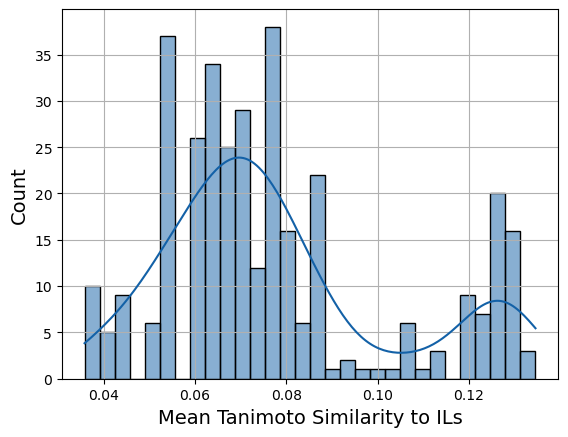

In [3]:
def compute_tanimoto(smiles1, smiles2):
    mols1 = [Chem.MolFromSmiles(sm) for sm in smiles1]
    mols2 = [Chem.MolFromSmiles(sm) for sm in smiles2]

    fps1 = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048) for m in mols1]
    fps2 = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048) for m in mols2]

    scores = []
    for fp in fps2:  
        similarities = [DataStructs.FingerprintSimilarity(fp, fp_ref) for fp_ref in fps1]
        scores.append(np.mean(similarities)) 

    return scores

df_ils = pd.read_excel("Hx_ILs(cur).xlsx")
df_dess = pd.read_excel("Hx_DESs(cur).xlsx")

df_dess["Tanimoto_to_ILs"] = compute_tanimoto(df_ils["SMILES_IL"].dropna().tolist(), df_dess["SMILES_DES"].dropna().tolist())


sns.histplot(df_dess["Tanimoto_to_ILs"], bins=30, kde=True, color="#1361a7")
plt.xlabel("Mean Tanimoto Similarity to ILs", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid()
plt.show()

lower, upper = 0.2, 0.55 
selected_dess = df_dess[(df_dess["Tanimoto_to_ILs"] >= lower) & (df_dess["Tanimoto_to_ILs"] <= upper)]

while selected_dess.empty and lower > 0.1:
    lower -= 0.05  
    upper += 0.05  
    selected_dess = df_dess[(df_dess["Tanimoto_to_ILs"] >= lower) & (df_dess["Tanimoto_to_ILs"] <= upper)]

In [4]:
ils= df_ils["SMILES_IL"]
mols = [Chem.AddHs(Chem.MolFromSmiles(smiles)) for smiles in ils]
cdk = CDK()
CDK_ils = cdk.calculate(mols)

The Chemistry Development Kit (CDK) is a collection of modular Java libraries
for processing chemical information (Cheminformatics). It can compute 14 different fingerprint
types and 287 molecular descriptors (it requires 3D molecular structures for the latter).

###################################

Should you publish results based on the PaDEL descriptors,
please cite:

Willighagen et al., (2017)  J. Cheminf. 9(3), doi:10.1186/s13321-017-0220-4,
May and Steinbeck., (2014) J. Cheminf., doi:10.1186/1758-2946-6-3,
Steinbeck et al., (2006) Curr. Pharm. Des. 12(17):2111-2120, doi:10.2174/138161206777585274,
Steinbeck et al., (2003) J. Chem. Inf. Comput. Sci. 43(2):493-500, doi:10.1021/ci025584y.

###################################




In [5]:
CDK_ils = CDK_ils.fillna(0)

In [6]:
hba= selected_dess["SMILES_HBA"]
mols = [Chem.AddHs(Chem.MolFromSmiles(smiles)) for smiles in hba]
cdk = CDK()
CDK_nba = cdk.calculate(mols)

The Chemistry Development Kit (CDK) is a collection of modular Java libraries
for processing chemical information (Cheminformatics). It can compute 14 different fingerprint
types and 287 molecular descriptors (it requires 3D molecular structures for the latter).

###################################

Should you publish results based on the PaDEL descriptors,
please cite:

Willighagen et al., (2017)  J. Cheminf. 9(3), doi:10.1186/s13321-017-0220-4,
May and Steinbeck., (2014) J. Cheminf., doi:10.1186/1758-2946-6-3,
Steinbeck et al., (2006) Curr. Pharm. Des. 12(17):2111-2120, doi:10.2174/138161206777585274,
Steinbeck et al., (2003) J. Chem. Inf. Comput. Sci. 43(2):493-500, doi:10.1021/ci025584y.

###################################




In [7]:
hbd= selected_dess["SMILES_HBD"]
mols = [Chem.AddHs(Chem.MolFromSmiles(smiles)) for smiles in hbd]
cdk = CDK()
CDK_nbd = cdk.calculate(mols)

The Chemistry Development Kit (CDK) is a collection of modular Java libraries
for processing chemical information (Cheminformatics). It can compute 14 different fingerprint
types and 287 molecular descriptors (it requires 3D molecular structures for the latter).

###################################

Should you publish results based on the PaDEL descriptors,
please cite:

Willighagen et al., (2017)  J. Cheminf. 9(3), doi:10.1186/s13321-017-0220-4,
May and Steinbeck., (2014) J. Cheminf., doi:10.1186/1758-2946-6-3,
Steinbeck et al., (2006) Curr. Pharm. Des. 12(17):2111-2120, doi:10.2174/138161206777585274,
Steinbeck et al., (2003) J. Chem. Inf. Comput. Sci. 43(2):493-500, doi:10.1021/ci025584y.

###################################




In [8]:
selected_dess = selected_dess.reset_index()
HBA = CDK_nba.multiply(selected_dess['x_HBA'], axis=0)
HBD = CDK_nbd.multiply(selected_dess['x_HBD'], axis=0)
HBA = HBA.fillna(0)
HBD = HBD.fillna(0)

In [9]:
cdk_result_des = (HBA + HBD) / 2

In [10]:
X_des = pd.concat([selected_dess["T"], cdk_result_des], axis=1)
y_des = selected_dess["Hx-Exp Mpa"]

In [13]:
X_ils = pd.concat([df_ils["T (K)"], CDK_ils], axis=1)
y_ils = df_ils["Henry's Constant H (MPa)"]

In [14]:
X_ils.rename(columns={'T (K)': 'T'},  inplace=True)

In [15]:
X =pd.concat([X_ils, X_des], axis=0)

In [16]:
X = X.reset_index()

C:\Users\Dmitriy\anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.


In [17]:
X = X.loc[:, ~np.isinf(X).any()].loc[:, (X != 0).any(axis=0)]
corr = X.corr().applymap(lambda x: 0 if x == 1 else x)
list_desc_cdk = corr[(corr <= 0.95)].dropna(how='all').index.tolist()
print('Number of descriptors CDK:', len(list_desc_cdk) - 1)

Number of descriptors CDK: 154


In [18]:
X = X[list_desc_cdk]

In [19]:
y = pd.concat([y_ils, y_des], axis=0, ignore_index=True)

In [20]:
#Random splitting

In [21]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []

for train_index, test_index in cv.split(X):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    rf = CatBoostRegressor(silent=True, iterations= 905, depth = 3, learning_rate = 0.21624738569732568, subsample=0.44167363309173513)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)

    Y_pred.extend(y_pred)
    Y_true.extend(y_test)

    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)

print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))

R^2 = 0.932 ± 0.018
RMSE = 1.42 ± 0.323
MAE = 0.823 ± 0.126
AARD = 11.585 ± 1.949


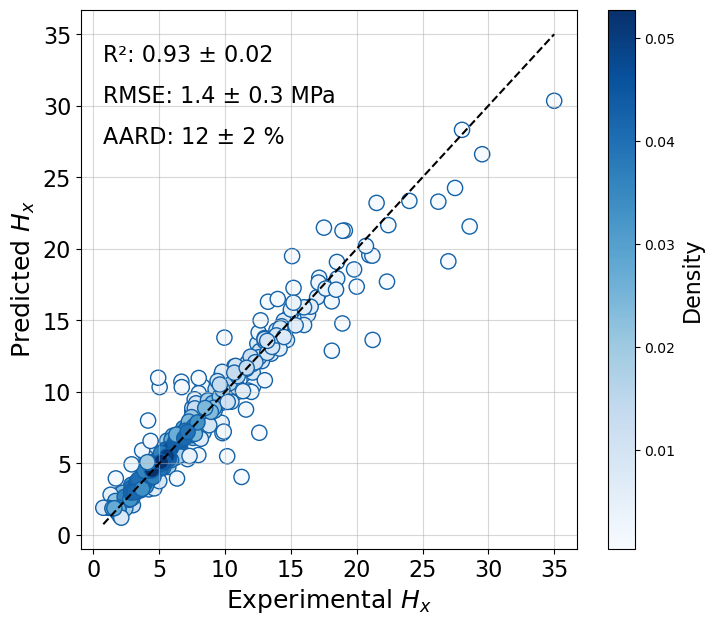

In [23]:
from scipy.stats import gaussian_kde


experimental = np.array(Y_true) 
predicted = np.array(Y_pred)  
errors = predicted - experimental

def calculate_aard(experimental, predicted):
    relative_errors = np.abs((experimental - predicted) / experimental)
    aard = np.mean(relative_errors) * 100  
    return aard

def scatter_density_plot(experimental, predicted):
    
    xy = np.vstack([experimental, predicted])
    z = gaussian_kde(xy)(xy)

    
    plt.figure(figsize=(8, 7))
    plt.subplot(1, 1, 1)
    scatter = plt.scatter(experimental, predicted, c=z, s=120, cmap='Blues', alpha=1, edgecolor='#1361a7')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density', fontsize=16)
    
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

    plt.plot([min(experimental), max(experimental)], [min(experimental), max(experimental)], 'k--')

    plt.xlabel(r'Experimental $H_x$', fontsize=18)
    plt.ylabel(r'Predicted $H_x$', fontsize=18)
    plt.grid(True, alpha=0.5)
    plt.text(min(experimental), max(predicted) - 3, f'R²: 0.93 ± 0.02 \nRMSE: 1.4 ± 0.3 MPa \nAARD: 12 ± 2 %', fontsize=16, linespacing=2)

scatter_density_plot(experimental, predicted)

In [24]:
#Strict splitting

In [25]:
class UniqueGroupKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        unique_groups = np.unique(groups)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(unique_groups)
        
        fold_size = len(unique_groups) // self.n_splits
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                test_groups = unique_groups[i * fold_size:]
            else:
                test_groups = unique_groups[i * fold_size: (i + 1) * fold_size]
            
            test_indices = np.where(np.isin(groups, test_groups))[0]
            train_indices = np.where(~np.isin(groups, test_groups))[0]
            
            if len(test_indices) > 0 and len(train_indices) > 0:
                yield train_indices, test_indices

In [26]:
cv = UniqueGroupKFold(n_splits=5, shuffle=True, random_state=42)

In [27]:
s =pd.concat([df_ils["SMILES_IL"], selected_dess["SMILES_DES"]], axis=0, ignore_index=True)

In [28]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []

for train_index, test_index in cv.split(X, groups=s):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    rf = CatBoostRegressor(silent=True)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    
   
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    
    
    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    
 
    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)


print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))

R^2 = 0.718 ± 0.148
RMSE = 2.836 ± 1.198
MAE = 1.713 ± 0.615
AARD = 22.687 ± 2.749


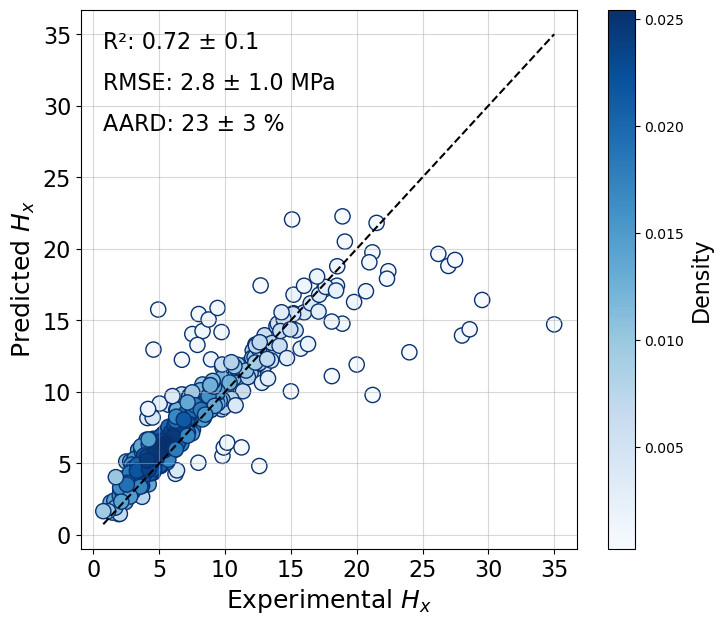

In [30]:
from scipy.stats import gaussian_kde

experimental = np.array(Y_true)
predicted = np.array(Y_pred)
errors = predicted - experimental

def calculate_aard(experimental, predicted):
    relative_errors = np.abs((experimental - predicted) / experimental)
    aard = np.mean(relative_errors) * 100  
    return aard

def scatter_density_plot(experimental, predicted):
    
    xy = np.vstack([experimental, predicted])
    z = gaussian_kde(xy)(xy)    
    plt.figure(figsize=(8, 7))

    
    plt.subplot(1, 1, 1)
    scatter = plt.scatter(experimental, predicted, c=z, s=120, cmap='Blues', alpha=1, edgecolor='#09316f')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density', fontsize=16)
    
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

   
    plt.plot([min(experimental), max(experimental)], [min(experimental), max(experimental)], 'k--')

    plt.xlabel(r'Experimental $H_x$', fontsize=18)
    plt.ylabel(r'Predicted $H_x$', fontsize=18)
    plt.grid(True, alpha=0.5)
    plt.text(min(experimental), max(predicted) + 6, f'R²: 0.72 ± 0.1 \nRMSE: 2.8 ± 1.0 MPa \nAARD: 23 ± 3 %', fontsize=16, linespacing=2)
scatter_density_plot(experimental, predicted)

In [31]:
#Applicability Domain

In [32]:
from sklearn.preprocessing import StandardScaler
import shap

In [33]:
n_samples = X.shape[0]

In [34]:
all_leverages = np.zeros(n_samples)
all_residuals = np.zeros(n_samples)

In [35]:
X=X.values

In [36]:
for fold, (train_idx, test_idx) in enumerate(cv.split(X, groups=s)):
    print(f' fold {fold+1}/5...')
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    
    model = CatBoostRegressor(verbose=0)
    model.fit(X_train, y_train)
    
   
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    
    shap_matrix = np.abs(shap_values)  
    leverage_shap = shap_matrix.sum(axis=1) 
    
   
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    std_residuals = residuals / np.std(residuals) 
    
    
    all_leverages[test_idx] = leverage_shap  
    all_residuals[test_idx] = std_residuals 

 fold 1/5...
 fold 2/5...
 fold 3/5...
 fold 4/5...
 fold 5/5...


In [37]:
h_star = np.percentile(all_leverages, 95) 
out_of_leverage = np.sum(all_leverages > h_star) 
out_of_residuals = np.sum((all_residuals < -3) | (all_residuals > 3))  

print(f'Number of points outside the SHAP lever threshold (L*): {out_of_leverage}')
print(f'Number of points outside the boundaries of standardized residuals (±3): {out_of_residuals}')

Number of points outside the SHAP lever threshold (L*): 19
Number of points outside the boundaries of standardized residuals (±3): 7


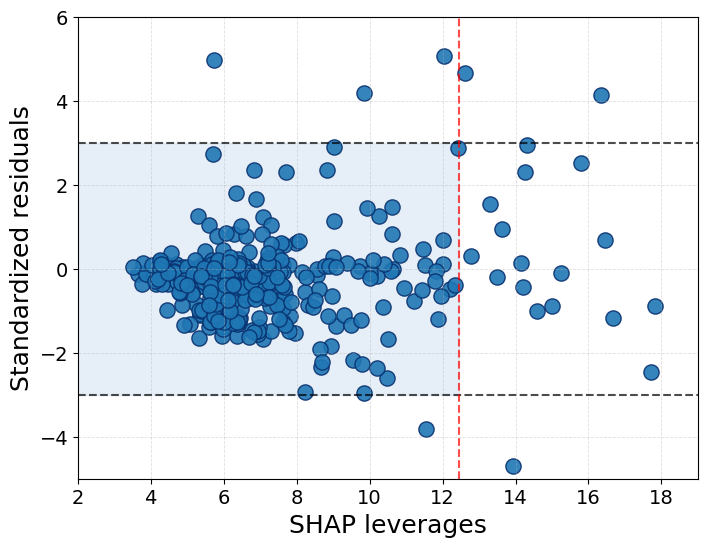

In [40]:
plt.figure(figsize=(8, 6))


plt.fill_between(
    x=[0, h_star], 
    y1=-3,  
    y2=3, 
    color='#cedff1', 
    alpha=0.5 
)
plt.scatter(
    all_leverages, 
    all_residuals, 
    s=120, 
    cmap='Blues', 
    edgecolors='#09316f',
    linewidth=1,
    alpha=0.9
)
plt.axhline(y=3, color='black', linestyle='--', alpha=0.7)
plt.axhline(y=-3, color='black', linestyle='--', alpha=0.7)
plt.axvline(x=h_star, color='red', linestyle='--', alpha=0.7)
plt.xlabel('SHAP leverages',fontsize=18)
plt.ylabel('Standardized residuals', fontsize=18)

plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.4)
plt.xlim(2, 19) 
plt.ylim(-5, 6) 
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()